<a href="https://colab.research.google.com/github/Erick-INCS/Corruption-analysis/blob/main/Bedu_ACM_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Importacion de las librerias

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats
from seaborn import kdeplot
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [3]:
# Load utils file
from requests import get
from pathlib import Path

ufile_name = 'project_utils.py'

if not Path(ufile_name).exists():
  utils_file = get('https://raw.githubusercontent.com/Erick-INCS/Corruption-analysis/main/utils/project_utils.py')
  utils_file = utils_file.text

  with open(ufile_name, 'wt') as utils_file_content:
    utils_file_content.write(utils_file)

from project_utils import (
    get_money, get_ds_asf, describe_chido, renom_estados,
    get_ds_pres_presi)

#### Datos del presupuesto

In [5]:
df_pres = get_ds_pres_presi()
df_pres.head(3)

,CICLO_RECURSO,PROGRAMA_FONDO_CONVENIO_ESPECIFICO,DESC_PARTIDA_GENERICA,DESC_TIPO_GASTO,ID_RAMO,MONTO_RECAUDADO,TRIMESTRE,MONTO_APROBADO,ID_PARTIDA_GENERICA,MONTO_EJERCIDO,MONTO_PAGADO,MONTO_DEVENGADO,MONTO_COMPROMETIDO,MONTO_MODIFICADO,TIPO_RECURSO,CICLO,DESC_RAMO,ENTIDAD_FEDERATIVA,MUNICIPIO,INSTITUCION_EJECUTORA,es_peña
122,2013,SIN IDENTIFICAR,Honorarios asimilables a salarios,Gasto corriente,12,14344718.31,1,14363368.9,121,14344718.31,14344718.31,14344718.31,14344718.31,14344718.31,"FEDERALES (APORTACIONES, SUBSIDIOS Y CONVENIOS)",2017,Salud,Aguascalientes,Gobierno de la Entidad,INSTITUTO DE SERVICIOS DE SALUD DEL EDO DE AGU...,True
123,2013,SIN IDENTIFICAR,"Materiales, útiles y equipos menores de oficina",Gasto corriente,12,44368.34,1,25704.7,211,22046.23,22046.23,22046.23,22046.23,44368.34,"FEDERALES (APORTACIONES, SUBSIDIOS Y CONVENIOS)",2017,Salud,Aguascalientes,Gobierno de la Entidad,INSTITUTO DE SERVICIOS DE SALUD DEL EDO DE AGU...,True
124,2013,SIN IDENTIFICAR,Materiales y útiles de impresión y reproducción,Gasto corriente,12,15080.00,1,150000.0,212,15080.00,15080.00,15080.00,15080.00,15080.00,"FEDERALES (APORTACIONES, SUBSIDIOS Y CONVENIOS)",2017,Salud,Aguascalientes,Gobierno de la Entidad,INSTITUTO DE SERVICIOS DE SALUD DEL EDO DE AGU...,True


### Datos para la clusterizacion

In [6]:
ds_random_forest = pd.read_csv('https://raw.githubusercontent.com/Erick-INCS/Corruption-analysis/main/datasets/ds_ml.csv', index_col=0)
print("Shape:", ds_random_forest.shape)
ds_random_forest.head()

Shape: (7287, 15)


,Número,Año Cuenta Pública,Espacio público,Densidad poblacional,Tratamiento de aguas residuales,Tasa de homicidios,Superﬁcie destinada a vías,Participación electoral,MONTO_MODIFICADO,MONTO_COMPROMETIDO,MONTO_PAGADO,MONTO_EJERCIDO,MONTO_APROBADO,es_peña,desaparecido_bool
0,9,2019,70.375625,89.311875,8.875,63.246875,67.298125,66.135625,1.317958e+11,8.079752e+10,6.519077e+10,6.545253e+10,1.134605e+11,False,False
1,18,2018,70.375625,89.311875,8.875,63.246875,67.298125,66.135625,3.356626e+10,2.884014e+10,2.789264e+10,2.791548e+10,2.411451e+10,True,False
2,18,2019,70.375625,89.311875,8.875,63.246875,67.298125,66.135625,1.317958e+11,8.079752e+10,6.519077e+10,6.545253e+10,1.134605e+11,False,False
3,19,2019,70.375625,89.311875,8.875,63.246875,67.298125,66.135625,1.317958e+11,8.079752e+10,6.519077e+10,6.545253e+10,1.134605e+11,False,False
4,22,2019,70.375625,89.311875,8.875,63.246875,67.298125,66.135625,1.317958e+11,8.079752e+10,6.519077e+10,6.545253e+10,1.134605e+11,False,False


In [7]:
std_scaler= StandardScaler()
data_cluster = ds_random_forest.drop(columns= ['Número','Año Cuenta Pública','es_peña','desaparecido_bool'])
data_cluster[data_cluster.columns] =std_scaler.fit_transform(data_cluster)

pca_2 = PCA(2)
pca_2_resultados = pca_2.fit_transform(data_cluster)

#### Clusterizacion

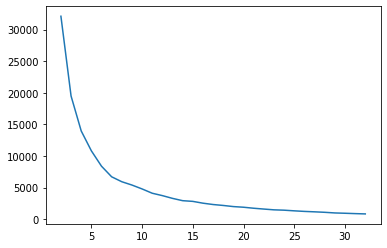

In [10]:
var=[]

for i in range(2,33):
  kmeans=KMeans(n_clusters=i, init="k-means++", random_state=15)
  kmeans.fit(pca_2_resultados)
  var.append(kmeans.inertia_)
  
sns.lineplot(x=range(2,33),y=var);



 [[-0.66123834 -0.08154436]
 [ 4.88996421  0.60303373]] 




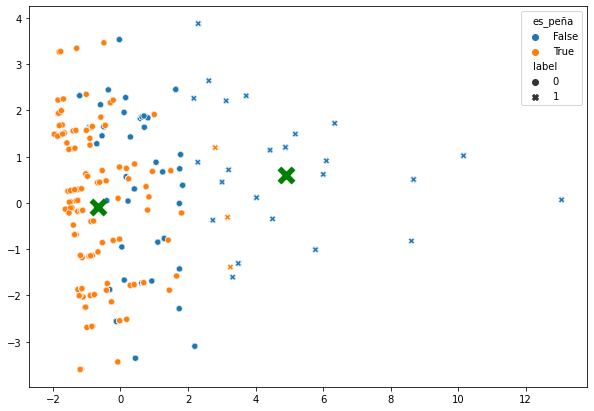

In [11]:
kmeans = KMeans(n_clusters=2, init="k-means++")
kmeans.fit(pca_2_resultados)
print('\n\n', kmeans.cluster_centers_, '\n\n')
clusters = kmeans.fit_predict(pca_2_resultados)
data_cluster["label"] = clusters

fig, ax = plt.subplots(figsize = (10, 7))
sns.scatterplot(x=pca_2_resultados[:,0], y=pca_2_resultados[:,1],style=data_cluster.label,hue=ds_random_forest.es_peña)
sns.scatterplot(x=kmeans.cluster_centers_[:,0], y=kmeans.cluster_centers_[:,1],
                color="green", marker="x", s=15, zorder=10,lw=10,linewidth=20,alpha=1);

#### Datos del presupuesto para la deteccion del presidente

In [12]:
m_size = min(df_pres[~df_pres['es_peña']].shape[0], df_pres[df_pres['es_peña']].shape[0])

los_penas = df_pres[df_pres['es_peña']]
los_amlos = df_pres[~df_pres['es_peña']].sample(m_size, replace=False)

ds_pres_presidente = los_penas.copy().append(los_amlos)
ds_pres_presidente = ds_pres_presidente[list(filter(lambda l: 'MONTO' in l or l == 'es_peña', list(ds_pres_presidente.columns)))]
ds_pres_presidente_X = ds_pres_presidente.copy().drop(['es_peña'], axis=1)
ds_pres_presidente_y = ds_pres_presidente['es_peña']

X_train, X_test, y_train, y_test = train_test_split(ds_pres_presidente_X, ds_pres_presidente_y, test_size=0.3)

#### Regresion logistica simple

In [13]:
clf = LogisticRegression().fit(X_train, y_train)
print('Score!:', clf.score(X_test, y_test))

y_pred = clf.predict(X_test)

Score!: 0.702112551038523


#### Random forest con validacion cruzada

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict

# scores = cross_validate(
#     RandomForestClassifier(),
#     ds_pres_presidente_X,
#     ds_pres_presidente_y,
#     scoring='accuracy')

# print('Scores:', scores.get('test_score'))
# print(f'Score del modelo: {scores["test_score"].mean():.3f} +/- {scores["test_score"].std():.3f}')
# # Score del modelo: 0.764 +/- 0.046


predictions = cross_val_predict(
    RandomForestClassifier(),
    ds_pres_presidente_X,
    ds_pres_presidente_y)

accuracy = (predictions == ds_pres_presidente_y).sum()/ds_pres_presidente_y.shape[0]
print("Random forest accuracy: ", accuracy, '%')

Random forest accuracy:  0.7647879322762916 %


#### Resultados

In [15]:
pred_result, org_values = predictions, ds_pres_presidente_y

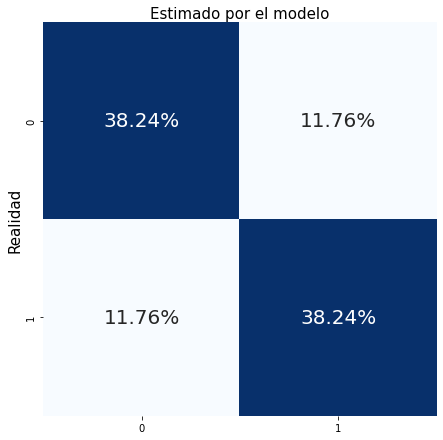

In [16]:
cnf_matrix = metrics.confusion_matrix(org_values, pred_result)

cnf_matrix = cnf_matrix/cnf_matrix.sum()
class_names=[0,1] # name  of classes
fig, ax = plt.subplots(figsize=(6, 6))
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues" ,fmt='.2%', cbar=False, annot_kws={"size": 20})
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.ylabel('Realidad', fontsize=15, y=0.5)
plt.xlabel('Estimado por el modelo', fontsize=15);

In [17]:
tn, fp, fn, tp = cnf_matrix.ravel()

print("Precision:",metrics.precision_score(org_values, pred_result))
print("Exactitud:",metrics.accuracy_score(org_values, pred_result))
print("Sensibilidad:",metrics.recall_score(org_values, pred_result))
print("Especificidad:", tn / (tn + fp))

Precision: 0.7648255430536814
Exactitud: 0.7647879322762916
Sensibilidad: 0.7647169217971738
Especificidad: 0.7648589427554094


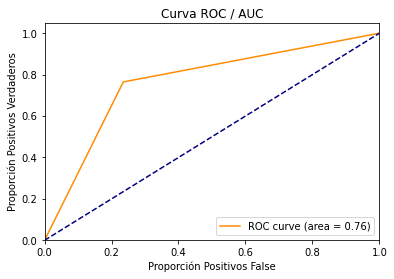

<Figure size 432x288 with 0 Axes>

In [18]:
fpr, tpr, _ = roc_curve(org_values, pred_result)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Proporción Positivos False')
plt.ylabel('Proporción Positivos Verdaderos')
plt.title('Curva ROC / AUC')
plt.legend(loc="lower right")
plt.show()
plt.savefig('ROC_RF.png')

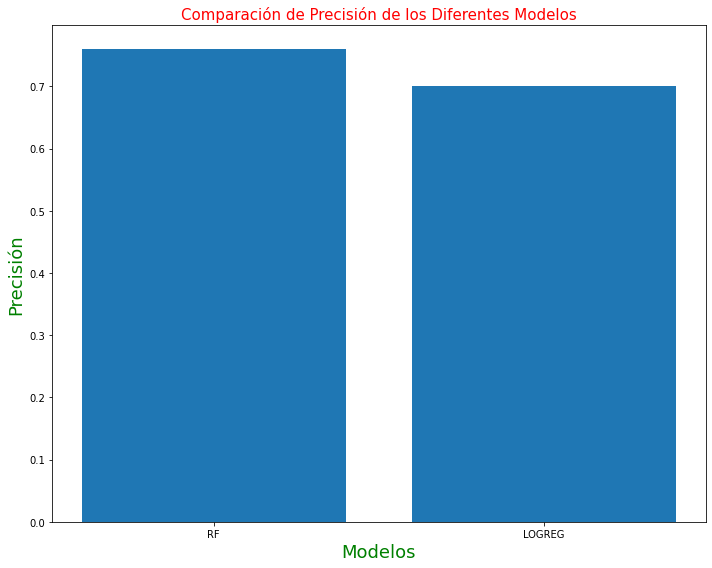

In [19]:
train_accuracy = [0.76,.70]
plt.figure(figsize=(10,8))
plt.bar([ 'RF', 'LOGREG'], train_accuracy)
plt.title('Comparación de Precisión de los Diferentes Modelos', fontsize=15, color='r')
plt.xlabel('Modelos', fontsize=18, color='g')
plt.ylabel('Precisión', fontsize=18, color='g')
plt.tight_layout()
plt.show()

## Clusterizacion de los datos del CPI

### Datos del CPI

In [ ]:
ds_cpi = pd.read_csv('https://raw.githubusercontent.com/Forever-D14/Corrupt_ML/main/CPI_Mex_full.csv')

ds_cpi['estado'] = ds_cpi['estado'].map(renom_estados)
ds_cpi.rename(columns = {'estado':'Entidad Federativa'},inplace=True)
ds_cpi_reduce = ds_cpi.groupby(['Entidad Federativa', 'municipio']).mean()
ds_cpi_reduce.head()

Accesibilidad al espacio público abierto  ...  Áreas verdes per cápita
Entidad Federativa municipio                                                            ...                         
Aguascalientes     Aguascalientes                                                73.28  ...                    54.65
                   Jesús María                                                   38.22  ...                    38.73
                   San Francisco de los Romo                                    100.00  ...                    17.93
Baja California    Ensenada                                                      28.97  ...                    26.14
                   Mexicali                                                      42.90  ...                    16.58

[5 rows x 67 columns]

###Reduccion de la Dimensionalidad del Dataset

Varianza acumulada explicada por mis dos nuevas variables: 31.91%


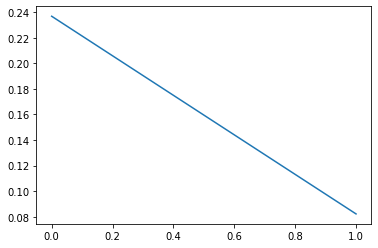

In [ ]:
std_scaler =  StandardScaler()
pca = PCA(2)
ds_cpi_reduce[ds_cpi_reduce.columns] = std_scaler.fit_transform(ds_cpi_reduce)


ds_cpi_reduce = ds_cpi_reduce.fillna(ds_cpi_reduce.mean())
pca.fit(ds_cpi_reduce)

plt.plot(
       range(len(pca.explained_variance_)),
       pca.explained_variance_ratio_
   )

print("Varianza acumulada explicada por mis dos nuevas variables: {:.2%}".format(np.sum(pca.explained_variance_ratio_)))

In [ ]:
ds_cpi_reduced = pd.DataFrame(
    pca.transform(ds_cpi_reduce),
    index=ds_cpi_reduce.copy().index)

ds_cpi_reduced.head()

0         1
Entidad Federativa municipio                                    
Aguascalientes     Aguascalientes            -3.166468 -0.060629
                   Jesús María               -1.205980 -1.490883
                   San Francisco de los Romo -1.270079  1.845789
Baja California    Ensenada                  -0.691337 -0.029676
                   Mexicali                  -4.274943  1.897700

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


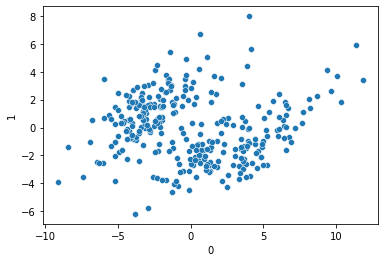

In [ ]:
sns.scatterplot(ds_cpi_reduced[0], ds_cpi_reduced[1]);

###Metodo del Codo

Donde nos indica que el numero optimo para nuestro modelo de KMeans es de 2 clusters


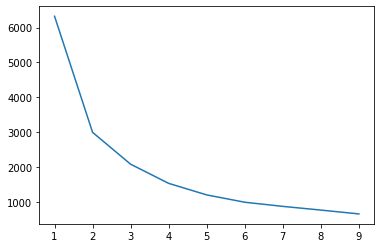

In [ ]:
var = []

for i in range(1,10):
  kmeans = KMeans(n_clusters = i, init = "k-means++")
  kmeans.fit(ds_cpi_reduced)

  var.append(kmeans.inertia_)

plt.plot(range(1,10),var);

In [ ]:
kmeans = KMeans(n_clusters = 2, init= "k-means++")
kmeans.fit(ds_cpi_reduced)
ds_cpi['cluster'] = kmeans.predict(ds_cpi_reduced)
ds_cpi_reduced['cluster'] = kmeans.predict(ds_cpi_reduced)

###Visualizamos los clusters con su centroide


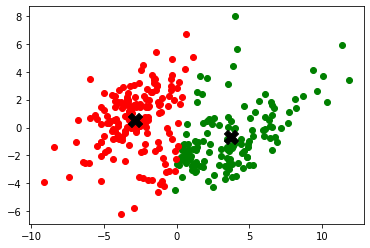

In [ ]:
plt.scatter(ds_cpi_reduced[0][ds_cpi_reduced['cluster'] == 0], ds_cpi_reduced[1][ds_cpi_reduced['cluster']==0], color = "green")
plt.scatter(ds_cpi_reduced[0][ds_cpi_reduced['cluster'] == 1], ds_cpi_reduced[1][ds_cpi_reduced['cluster']==1], color = "red")
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],color = "k",marker='X', s=200)

###Promedio por Cluster en cada una de las variables

Dentro de estos promedios podemos concluir mediante las variables que:


*   Cluster 0 = Ciudades Rurales
*   Cluster 1 = Ciudades Urbanas



In [ ]:
data2= ds_cpi_reduce.drop(columns = ['Energía', 'Proporción de generación de energía renovable'])
data2['cluster'] = ds_cpi_reduced['cluster']
data2.groupby('cluster').mean()

,Accesibilidad al espacio público abierto,Acceso a Internet,Acceso a agua mejorada,Aglomeración económica,CALIDAD DE VIDA,Calidad del aire,Capacidad institucional y ﬁnanzas municipales,Coeﬁciente de Gini,Concentraciones de material particulado,Concentración de CO2,Crecimiento económico,Densidad de la interconexión vial,Densidad de médicos,Densidad económica,Densidad poblacional,Densidad vial,Desempleo juvenil,Deuda subnacional,EQUIDAD E INCLUSIÓN SOCIAL,Educación,Empleo,Equidad económica,Espacio habitable suﬁciente,Espacio público,Esperanza de vida al nacer,Eﬁciencia del gasto local,Eﬁciencia en el uso de suelo,Fatalidades de tránsito,Forma urbana,GOBERNANZA Y LEGISLACIÓN URBANA,Gobernanza de la urbanización,INFRAESTRUCTURA DE DESARROLLO,Inclusión de género,Inclusión social,Infraestructura de comunicaciones,Infraestructura de vivienda,Infraestructura social,Inscripción equitativa en educación a nivel secundario,Longitud de transporte masivo,Manejo de residuos,Movilidad urbana,Número de estaciones de monitoreo,PRODUCTIVIDAD,Participación electoral,Participación y rendición de cuentas,Producto urbano per cápita,Promedio de años de escolaridad,Recaudación de ingresos propios,Recolección de residuos sólidos,Relación de dependencia de la tercera edad,Relación empleo-población,SOSTENIBILIDAD AMBIENTAL,Salud,Seguridad y protección,Superﬁcie destinada a vías,Tasa de alfabetización,Tasa de desempleo,Tasa de homicidios,Tasa de mortalidad de menores de 5 años,Tasa de pobreza,Tratamiento de aguas residuales,Velocidad de banda ancha promedio,Vivienda durable,Viviendas en barrios precarios,Áreas verdes per cápita
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.341900,-0.383173,-0.319858,-0.659945,0.129088,-0.415528,-0.701686,0.018317,-0.532055,0.0,-0.754653,-0.170100,-0.500230,-0.659945,-0.555152,-0.317506,0.048041,-0.420342,-0.333464,-0.866573,-0.802843,-0.613990,0.0,0.511237,-0.032494,-0.360696,0.369476,-0.058966,-0.410225,0.098054,0.369476,-0.366355,0.066264,-0.174813,-0.052818,-0.575189,-0.500230,0.066264,-0.113675,-0.282362,0.265842,0.085767,-0.867626,0.275881,0.275881,-0.667852,-0.885132,-0.658459,-0.429404,-0.394014,-0.858137,-0.024988,0.451120,-0.105361,-0.566755,-0.431845,-0.566114,-0.105361,0.486992,-0.776819,-0.370684,0.866920,-0.265321,-0.214657,0.695902
1,0.260871,0.292363,0.244054,0.503542,-0.098495,0.317051,0.535390,-0.013976,0.405961,0.0,0.575805,0.129787,0.381679,0.503542,0.423584,0.242259,-0.036655,0.320723,0.254435,0.661200,0.612573,0.468478,0.0,-0.390077,0.024793,0.275213,-0.281912,0.044991,0.313004,-0.074816,-0.281912,0.279531,-0.050560,0.133383,0.040301,0.438872,0.381679,-0.050560,0.086735,0.215444,-0.202839,-0.065441,0.662004,-0.210499,-0.210499,0.509575,0.675361,0.502408,0.327638,0.300635,0.654764,0.019066,-0.344207,0.080391,0.432438,0.329500,0.431948,0.080391,-0.371578,0.592717,0.282834,-0.661465,0.202441,0.163784,-0.530977
